In [35]:
from train_spikes import *

In [36]:
# load data
data = pd.read_csv("data/lfp_spikes.csv")

In [6]:
import tensorflow.keras.models as models

In [7]:
num_dimensions = 15
num_neurons = 52

In [8]:
# average number of spikes in 1000 ms time period
spikes_array = np.array(data.iloc[:,num_dimensions:num_dimensions + num_neurons])
np.mean(np.sum(spikes_array, axis = 0)/1000)

7.009884615384616

## Plot differences between successive spike times

In [9]:
diffs = []
spikes_array = np.array(data.iloc[:,num_dimensions:num_dimensions+ num_neurons])
for j in range(spikes_array.shape[1]):
    for i in range(spikes_array.shape[0]):
        if i % 1000 == 0:
            start = -1
        if spikes_array[i, j] == 1:
            if start != -1:
                diffs.append(i - start)
            start = i

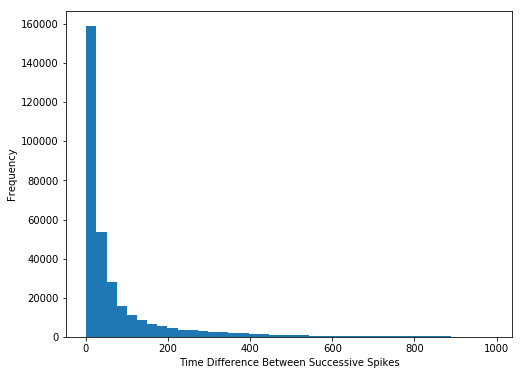

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
plt.hist(diffs, bins = 40)
plt.xlabel("Time Difference Between Successive Spikes")
plt.ylabel("Frequency")
plt.savefig("spike_dist")
plt.show()


In [12]:
num_trials = max(data.trial_index) + 1
train_inds, test_inds, val_inds = train_test_val_split(num_trials)

In [13]:
trials = create_trials(data, num_trials)
trials, means, stds = normalize_trials(trials, train_inds, num_dimensions)

# Error Analysis

In [14]:
import matplotlib.pyplot as plt
timestep_array = [100, 50 , 10]
lags = [1, 5, 10, 50]
bin_sizes = [1, 5, 10, 50]
times = [i for i in range(-499, 501)]
trial_length = 1000

In [37]:
aucs = np.load("spike_errors/aucs.npy")
min_aucs = np.load("spike_errors/auc_mins.npy")
max_aucs = np.load("spike_errors/auc_maxs.npy")

### AUC Table by lag and bin size, for selected number of timesteps

In [17]:
timestep_index = 0 # set to choose number of timesteps
df = pd.DataFrame(aucs[timestep_index])
df = df.rename(index = lambda x: lags[x], columns = lambda x: bin_sizes[x])
df

,1,5,10,50
1,0.804222,0.806956,0.802504,0.782005
5,0.795594,0.795725,0.791307,0.776432
10,0.781485,0.782693,0.779826,0.772935
50,0.732593,0.740839,0.739037,0.749221


### Table for minimum AUC across all neurons, by lag and bin size, for selected number of timesteps

In [18]:
timestep_index = 0 # set to choose number of timesteps
df = pd.DataFrame(min_aucs[timestep_index])
df = df.rename(index = lambda x: lags[x], columns = lambda x: bin_sizes[x])
df

,1,5,10,50
1,0.577601,0.575235,0.568954,0.547003
5,0.557981,0.566647,0.562672,0.531481
10,0.535724,0.559511,0.556925,0.510667
50,0.462052,0.526399,0.518141,0.510558


### Table for maximum AUC across all neurons, by lag and bin size, for selected number of timesteps

In [19]:
timestep_index = 0 # set to choose number of timesteps
df = pd.DataFrame(max_aucs[timestep_index])
df = df.rename(index = lambda x: lags[x], columns = lambda x: bin_sizes[x])
df

,1,5,10,50
1,0.899964,0.888378,0.873639,0.793291
5,0.870187,0.869369,0.855002,0.782231
10,0.845701,0.846225,0.835472,0.779408
50,0.755977,0.769520,0.759613,0.724391


## Probability of a spike at different time points in trial

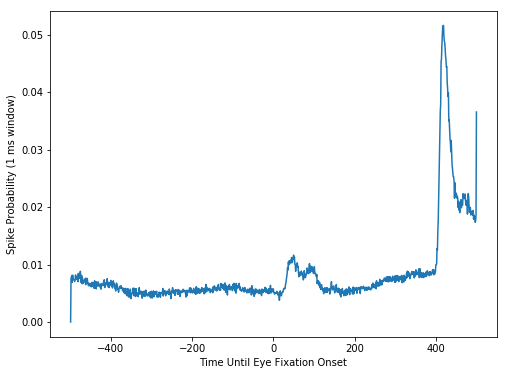

In [21]:
plt.figure(figsize = (8, 6))
sums = np.zeros((1000, 52))
for key in trials:
    sums += trials[key][:,15:]
sums /= len(trials)
plt.plot(times, np.mean(sums, axis =1))
plt.xlabel('Time Until Eye Fixation Onset')
plt.ylabel('Spike Probability (1 ms window)')
plt.savefig('spike_probs_by_time')
plt.show()


## Plots AUC by timesteps and lag, for selected bin size

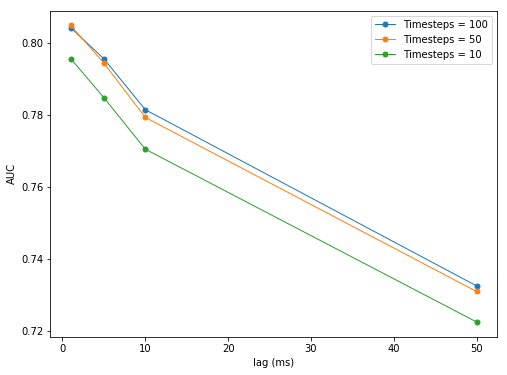

In [22]:
plt.figure(figsize = (8,6))
bin_index = 0 # change this to select bin size
for i in range(len(timestep_array)):
    timesteps = timestep_array[i]
    plt.plot(lags, aucs[i,:, bin_index], marker = 'o', ms = 5, label = 'Timesteps = ' + str(timesteps), linewidth = 1)
    plt.xlabel('lag (ms)')
    plt.ylabel('AUC')
plt.legend()
plt.savefig('lag_timestep_auc_spike')
plt.show()

# AUCs by time

### The 3 cells below plots AUC, and AUC by time point in trial for a specific lag, timestep, and bin size

In [30]:
# choose timestep, lag, and bin size by indexing their arrays
timestep_index = 0
lag_index = 0
bin_size_index = 3
timesteps, lag, bin_size = timestep_array[timestep_index], lags[lag_index], bin_sizes[bin_size_index]
timesteps_lag_bin_size = str(timesteps) + '_' + str(lag) + '_' + str(bin_size)
aucs_by_time = np.load('spike_errors/auc_time_' + timesteps_lag_bin_size + '.npy')
start = timesteps + lag + bin_size - 2

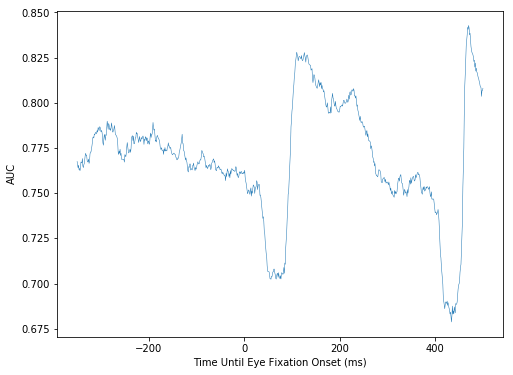

In [31]:
plt.figure(figsize = (8, 6))
plt.plot(times[start:], aucs_by_time, linewidth = .5)
plt.xlabel("Time Until Eye Fixation Onset (ms)")
plt.ylabel("AUC")
plt.savefig('auc_by_time_spike')
plt.show()

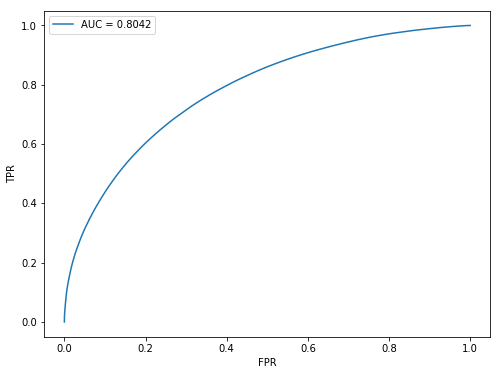

In [32]:
bin_size_index = 0
fpr = np.load('spike_errors/fpr_' + timesteps_lag_bin_size + '.npy')
tpr = np.load('spike_errors/tpr_' + timesteps_lag_bin_size + '.npy')
plt.figure(figsize= (8,6))
plt.plot(fpr, tpr, label = 'AUC = ' + "{0:.4f}".format(aucs[timestep_index, lag_index, bin_size_index]))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

## The cell below plots AUC across several lags, for a given timestep and bin size

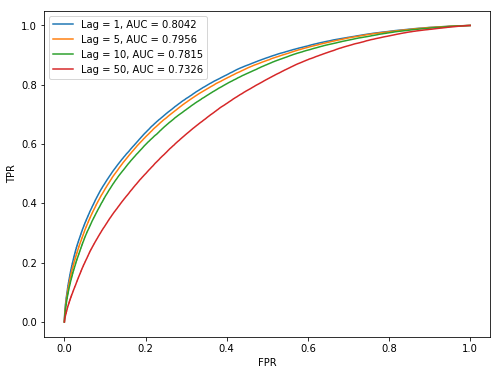

In [33]:
plt.figure(figsize = (8,6))
bin_size_index = 0
timestep_index = 0
for j in range(len(lags)):
    timesteps, lag, bin_size = timestep_array[timestep_index], lags[j], bin_sizes[bin_size_index]
    timesteps_lag_bin_size = str(timesteps) + '_' + str(lag) + '_' + str(bin_size)
    fpr = np.load('spike_errors/fpr_' + timesteps_lag_bin_size + '.npy')
    tpr = np.load('spike_errors/tpr_' + timesteps_lag_bin_size + '.npy')
    plt.plot(fpr, tpr, label = 'Lag = ' + str(lag) + ', AUC = ' + "{0:.4f}".format(aucs[timestep_index, j, bin_size_index]))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('spike_roc')
plt.show()

In [34]:
# loads model for specific timestep, lag, and bin size
timestep_index = 0
lag_index = 0
bin_size_index = 0
timesteps, lag, bin_size = timestep_array[timestep_index], lags[lag_index], bin_sizes[bin_size_index]
timesteps_lag_bin_size = str(timesteps) + '_' + str(lag) + '_' + str(bin_size)

model = models.load_model('spike_models/mdl_' + timesteps_lag_bin_size + '.h5')
trial_sequences = trial_targets = X_train = y_train = X_test = y_test = X_val = y_val = 0
trial_sequences, trial_targets, X_train, y_train, X_test, y_test, X_val, y_val =\
create_sequences(trials, train_inds, test_inds, val_inds, timesteps, num_neurons, lag, num_dimensions, bin_size)

OSError: Unable to open file (unable to open file: name = 'spike_models/mdl_100_50_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [31]:
# choose a specific trial to visualize spike prediction
ind = 0 # choose trial index
sequence, target = trial_sequences[test_inds[ind]], trial_targets[test_inds[ind]] # load sequence and target for a trial

## Visualizes true spikes, and spike predictions, for a single trial

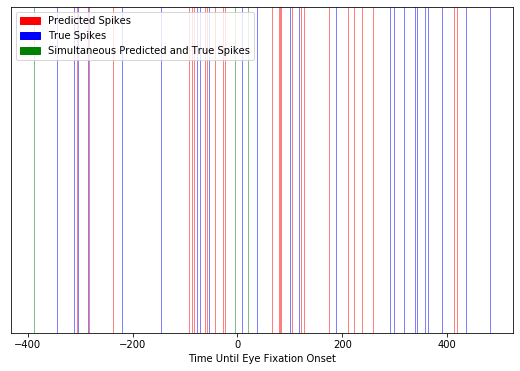

In [89]:
import matplotlib.patches as mpatches
neuron = 0
plt.figure(figsize = (9, 6))
y_pred = model.predict(sequence)[:, neuron]
cutoff_prob = .0656 # cutoff probability for predicting a spike 
y_pred = [1 if x > cutoff_prob else 0 for x in y_pred]
y_true = target[:, neuron]
neuron = 0
for i in range(len(y_pred)):
    if y_pred[i] == 1 and y_true[i] == 0:
        plt.axvline(x = i + 100-500, color = 'red', linewidth = .5)
    if y_true[i] == 1 and y_pred[i] == 0:
        plt.axvline(x = i + 100 - 500, color = 'blue', linewidth = .5)
    if y_true[i] == 1 and y_pred[i] == 1:
        plt.axvline(x = i + 100 - 500, color = 'green', linewidth = .5)
red_patch = mpatches.Patch(color='red', label='Predicted Spikes')
blue_patch = mpatches.Patch(color='blue', label='True Spikes')
green_patch = mpatches.Patch(color ='green', label ='Simultaneous Predicted and True Spikes')
plt.yticks([],[])
plt.xlabel('Time Until Eye Fixation Onset')
plt.legend(handles = [red_patch, blue_patch, green_patch])
plt.savefig('spike_trial_predictions')
plt.show()

In [74]:
# number of true positives (i.e we predicted a spike, and it occured)
sum(np.array(y_pred).astype('int') & np.array(y_true).astype('int'))

3

## Plots distribution of AUCs across all 52 neurons

In [62]:
from sklearn import metrics
aucs = []
for i in range(num_neurons):
    aucs.append(metrics.roc_auc_score(y_test[:,i], y_pred[:,i]))

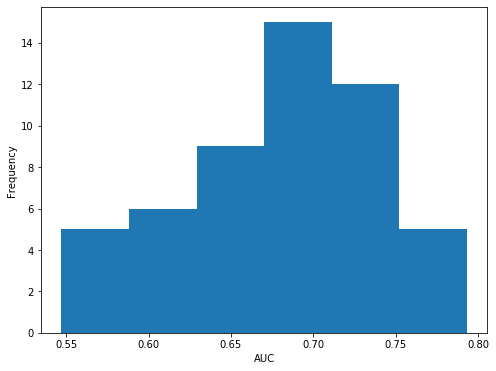

In [72]:
plt.figure(figsize = (8,6))
plt.hist(aucs, bins = 6)
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.savefig('auc_distribution')
plt.show()